In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import requests
from zipfile import ZipFile
from IPython.display import Markdown

# Intro

I'll be using a dataset of statements evaluated by POLITIFACT, a website focused on fact checking statements from public figures. The data contains more than 10,000 statements from a variety of public figures from a variety of contexts. Each statement is rated for its veracity on the following scale, ranging from totally bogus to totally true: "pants-fire", "false", "barely-true", "half-true", "mostly-true", and "true".

The dataset is hosted here: https://datasets.activeloop.ai/docs/ml/datasets/liar-dataset/.

The hosts offer an API to query the data directly, but it requires installation of a separate library. Instead, I'll download the zipped data directly from the following site: https://www.cs.ucsb.edu/~william/data/liar_dataset.zip.

1. Research Question

I'd like to survey various Natural Language Processing (NLP) and Machine Learning (ML) techniques for their ability to detect false public statements (sometimes referred to as "fake news"). In particular, I'd like to compare predictive accuracy when using different vectorization techniques, ranging from relatively simple (e.g. TF-IDF) to more complex (pre-trained LLMs, such as BERT or GPT). Once that's complete, I plan to compare perform for classification with various modeling techniques, again ranging from more simple (e.g. logistic regression) to more complex (e.g. XGBoost).

2. Justification - why is this relevant to you or industry?

I am most interested in applications of NLP to engineer features that can be used by more "traditional" predictive models. In particular, I'm interested in the ability to consume large amounts of textual data for support in policy analysis.

3. Data Sources - did you find this data online or collect yourself? Provide links.

I found this data source through the Papers With Code websites Datasets library: https://paperswithcode.com/datasets?task=fake-news-detection&page=1.

4. Libraries potentially being used.

I plan to leverage `pandas` for data aggregation and cleaning. For vectorization of text statements, I plan to leverage `sklearn` and the `transformers` library from `pytorch`, which allows one to download pre-trained LLMs to generate embeddings. I'll also likely leverage the `spacey` library for other cleaning (namely lemmitization and handling of named entities). Finally, I'll use `sklearn` once again for model fitting, prediction and performance assessment.

5. EDA and summary statistics.
Below, I'll read in the data and perform cursory analysis.

# Read in Data

In [2]:
# download zip file
url = 'https://www.cs.ucsb.edu/~william/data/liar_dataset.zip'

request = requests.get(url)
with open('data/liar_dataset.zip', 'wb') as fd:
    fd.write(request.content)

# unzip and see what's inside
zf = ZipFile('data/liar_dataset.zip')
zf.extractall(path = 'data')
zf.close()
zf.namelist()

['README', 'test.tsv', 'train.tsv', 'valid.tsv']

We now have three data files (one each for model training, model testing and final validation) along with a README. Let's start by looking over the README.

In [3]:
# render the README file
Markdown("data/README")

LIAR: A BENCHMARK DATASET FOR FAKE NEWS DETECTION

William Yang Wang, "Liar, Liar Pants on Fire": A New Benchmark Dataset for Fake News Detection, to appear in Proceedings of the 55th Annual Meeting of the Association for Computational Linguistics (ACL 2017), short paper, Vancouver, BC, Canada, July 30-August 4, ACL.
=====================================================================
Description of the TSV format:

Column 1: the ID of the statement ([ID].json).
Column 2: the label.
Column 3: the statement.
Column 4: the subject(s).
Column 5: the speaker.
Column 6: the speaker's job title.
Column 7: the state info.
Column 8: the party affiliation.
Column 9-13: the total credit history count, including the current statement.
9: barely true counts.
10: false counts.
11: half true counts.
12: mostly true counts.
13: pants on fire counts.
Column 14: the context (venue / location of the speech or statement).

Note that we do not provide the full-text verdict report in this current version of the dataset,
but you can use the following command to access the full verdict report and links to the source documents:
wget http://www.politifact.com//api/v/2/statement/[ID]/?format=json

======================================================================
The original sources retain the copyright of the data.

Note that there are absolutely no guarantees with this data,
and we provide this dataset "as is",
but you are welcome to report the issues of the preliminary version
of this data.

You are allowed to use this dataset for research purposes only.

For more question about the dataset, please contact:
William Wang, william@cs.ucsb.edu

v1.0 04/23/2017



The data does not have column heads, so we'll need to assign them manually. The README file above gives us those names, so we'll need to account for that when we read in each file.

In [4]:
# define list of column names
columns = [
    'id',
    'label',
    'statement',
    'subjects',
    'speaker',
    'speaker_job',
    'state',
    'party', 
    'barely_true',
    'false',
    'half_true',
    'mostly_true',
    'pants_on_fire',
    'context'
]

# loop through each file and read in as a pandas dataframe
files = ['test', 'train', 'valid']

for file in files:
    filename = 'data/' + file + '.tsv'
    globals()[file] = pd.read_csv(filename, sep = '\t', names = columns)
    os.remove(filename)
    
    print(f'{file} - No. observations: {len(globals()[file])}')
    display(globals()[file].head())

# delete the zip files to keep our directory clean
os.remove('data/liar_dataset.zip')
os.remove('data/README')

test - No. observations: 1267


,id,label,statement,subjects,speaker,speaker_job,state,party,barely_true,false,half_true,mostly_true,pants_on_fire,context
0,11972.json,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview
1,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference
2,11096.json,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.
3,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show
4,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,2,2,7,a web video


train - No. observations: 10240


,id,label,statement,subjects,speaker,speaker_job,state,party,barely_true,false,half_true,mostly_true,pants_on_fire,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


valid - No. observations: 1284


,id,label,statement,subjects,speaker,speaker_job,state,party,barely_true,false,half_true,mostly_true,pants_on_fire,context
0,12134.json,barely-true,We have less Americans working now than in the...,"economy,jobs",vicky-hartzler,U.S. Representative,Missouri,republican,1,0,1,0,0,an interview with ABC17 News
1,238.json,pants-fire,"When Obama was sworn into office, he DID NOT u...","obama-birth-certificate,religion",chain-email,NaN,NaN,none,11,43,8,5,105,NaN
2,7891.json,false,Says Having organizations parading as being so...,"campaign-finance,congress,taxes",earl-blumenauer,U.S. representative,Oregon,democrat,0,1,1,1,0,a U.S. Ways and Means hearing
3,8169.json,half-true,Says nearly half of Oregons children are poor.,poverty,jim-francesconi,Member of the State Board of Higher Education,Oregon,none,0,1,1,1,0,an opinion article
4,929.json,half-true,On attacks by Republicans that various program...,"economy,stimulus",barack-obama,President,Illinois,democrat,70,71,160,163,9,interview with CBS News


# Preliminary EDA

### Data Types

I'll start by viewing the datatype of each column.

In [5]:
train.dtypes

id                object
label             object
statement         object
subjects          object
speaker           object
speaker_job       object
state             object
party             object
barely_true      float64
false            float64
half_true        float64
mostly_true      float64
pants_on_fire    float64
context           object
dtype: object

The only numeric columns are the counts of statements under each rating. Per the README, it appears these counts are aggregated PER SPEAKER. So, if we filter for a single speaker, we should expect the same values. Let's check to make sure.

In [6]:
display(train.loc[train.speaker == 'barack-obama'].label.value_counts())
print('\n')
display(train[train.speaker == 'barack-obama'].iloc[0:10, 8:13])

label
mostly-true    130
half-true      124
true           103
false           67
barely-true     56
pants-fire       8
Name: count, dtype: int64

,barely_true,false,half_true,mostly_true,pants_on_fire
2,70.0,71.0,160.0,163.0,9.0
7,70.0,71.0,160.0,163.0,9.0
16,70.0,71.0,160.0,163.0,9.0
74,70.0,71.0,160.0,163.0,9.0
105,70.0,71.0,160.0,163.0,9.0
114,70.0,71.0,160.0,163.0,9.0
145,70.0,71.0,160.0,163.0,9.0
214,70.0,71.0,160.0,163.0,9.0
220,70.0,71.0,160.0,163.0,9.0
244,70.0,71.0,160.0,163.0,9.0


While the values are consistent across all of Obama's rows, they don't reconcile with my manual counts. I suspect this may be because the counts here include counts from the testing and validation subsets. Let's check.

In [7]:
# concatenate value_counts for the three dataframes to see the sum
pd.concat([
    train.loc[train.speaker == 'barack-obama'].label.value_counts().reset_index(),
    valid.loc[valid.speaker == 'barack-obama'].label.value_counts().reset_index(),
    test.loc[test.speaker == 'barack-obama'].label.value_counts().reset_index()
]).groupby('label').sum().reset_index()

,label,count
0,barely-true,70
1,false,81
2,half-true,165
3,mostly-true,163
4,pants-fire,9
5,true,123


Oddly, we see some discpreancies. Specifically, the count of 'barely true' and 'pants on fire' statements match. But the number of 'false', 'half true', and 'mostly true' statements do not match. Moreover, the count of 'true' statements is missing.

I think I'll avoid this column, as it appears to be lacking in quality. If I require any counts of statements by speaker, I'll construct them myself.

### Visuals

Let's take a look at some plots to better understand the data.

I'll start with a plot of the top 5 speakers by each rating label.

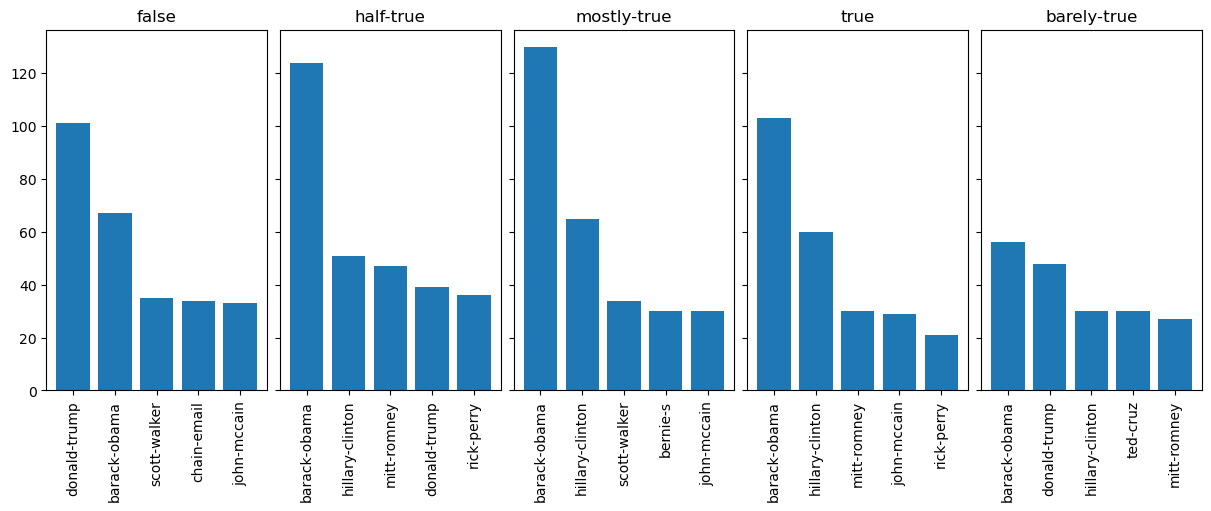

In [8]:
# to get a better sense 

fig, axes = plt.subplots(
    1, 5, 
    figsize = (12,5),
    layout = 'constrained',
    sharey = True
)

for rating, ax in zip(train.label.unique(), range(5)):
    top5 = train[train.label == rating].speaker.value_counts().head(5)
    axes[ax].bar(top5.index, top5.values)
    axes[ax].set_title(rating)
    axes[ax].tick_params(axis = 'x', rotation = 90)

plt.show()

Interesting...

Let's look at the overall distribution of speakers, parties, and contexts for each statament. We'll group the distributions to highlight the top 10 categories for each variable, then sum the remainder under the "other" label.

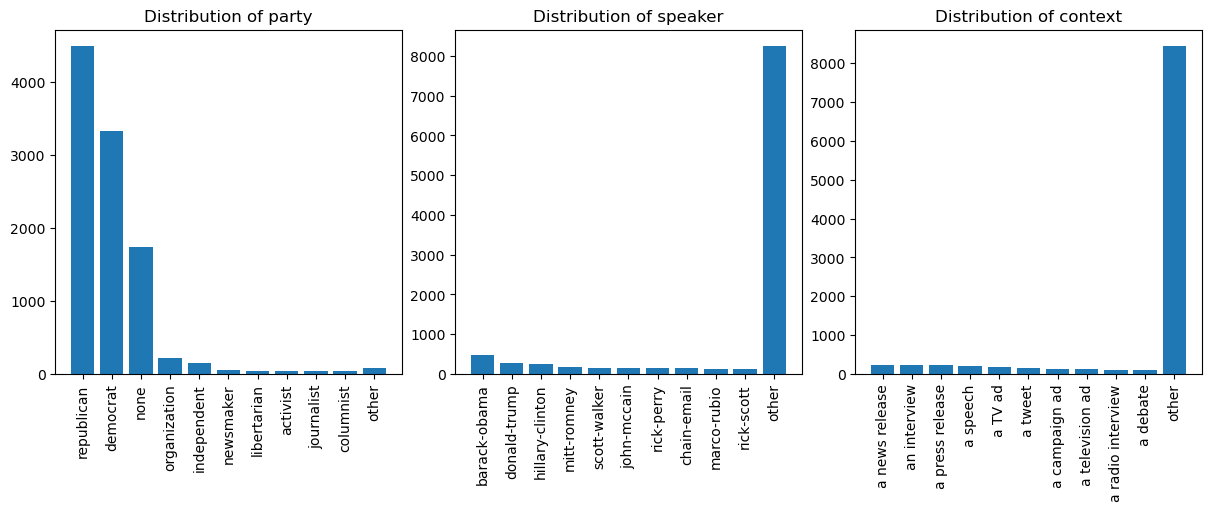

In [9]:
fig, axes = plt.subplots(1, 3, figsize = (12,5), layout = 'constrained')

for col, ax in zip(['party', 'speaker', 'context'], range(3)):
    counts = train[col].value_counts()
    top10 = counts.head(10)
    other = counts.iloc[10:].sum()
    top10['other'] = other
    
    axes[ax].bar(top10.index, top10.values)
    axes[ax].set_title(f'Distribution of {col}')
    axes[ax].tick_params(axis = 'x', rotation = 90)
    
plt.show()

Finally, let's take a look at the distribution of statements by rating, by party, and then by a combination of the two.

C:\Users\Keith\AppData\Local\Temp\ipykernel_2624\2079160591.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('label').party_simple.value_counts().unstack()


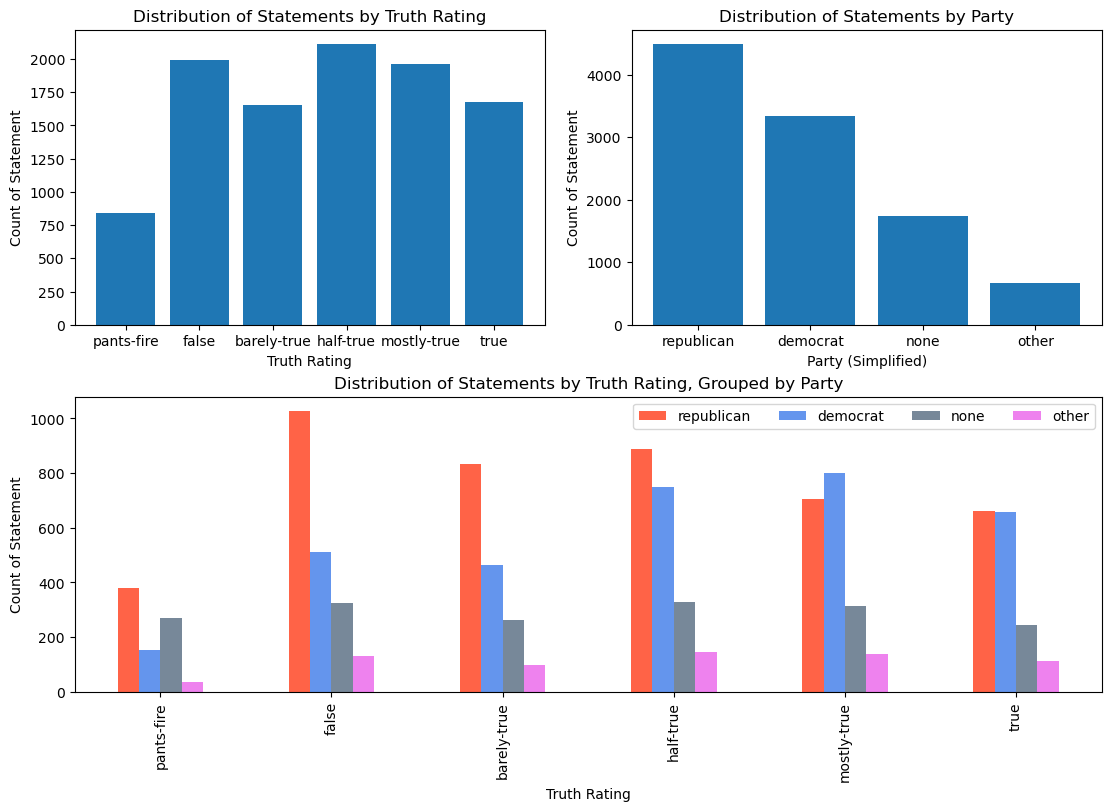

In [10]:
train['party_simple'] = train.party.apply(
    lambda x: x if x == 'democrat' or x == 'republican' or x == 'none' else 'other'
)

truth_order = ['pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true', 'true']
party_order = ['republican', 'democrat', 'none', 'other']
train.label = pd.Categorical(train.label, truth_order)
train.party_simple = pd.Categorical(train.party_simple, party_order)

plt.figure(figsize = (11,8), layout = 'constrained')

ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan = 2)

ax1.bar(
    train.label.value_counts().reindex(truth_order).index,
    train.label.value_counts().reindex(truth_order).values
)
ax1.set_xlabel('Truth Rating')
ax1.set_ylabel('Count of Statement')
ax1.set_title('Distribution of Statements by Truth Rating')

ax2.bar(
    train.party_simple.value_counts().index,
    train.party_simple.value_counts().values
)
ax2.set_xlabel('Party (Simplified)')
ax2.set_ylabel('Count of Statement')
ax2.set_title('Distribution of Statements by Party')

(train
 .groupby('label').party_simple.value_counts().unstack()
 .plot(kind='bar', ax = ax3, color=['tomato', 'cornflowerblue', 'lightslategrey', 'violet'])
)
ax3.legend(ncol = 4)
ax3.set_xlabel('Truth Rating')
ax3.set_ylabel('Count of Statement')
ax3.set_title('Distribution of Statements by Truth Rating, Grouped by Party')

plt.show()

In [16]:
for df, df_name in zip([train, valid, test], ['train', 'valid', 'test']):
    df.to_csv(f'data/liars_{df_name}.csv', index = False)